### QUANTITATIVE ANALYSIS - TECHNICAL INDICATORS
===================================================

This notebook performs quantitative analysis on stock price data using technical indicators:

1. DATA PREPARATION
   - Download historical stock prices via yfinance
   - Clean and validate OHLCV (Open, High, Low, Close, Volume) data
   - Align dates with news data timeline

2. TECHNICAL INDICATORS
   - Simple Moving Averages (SMA): 20-day, 50-day
   - Exponential Moving Averages (EMA): 12-day, 26-day
   - MACD (Moving Average Convergence Divergence): Signal and Histogram
   - RSI (Relative Strength Index): 14-day period
   - Bollinger Bands: 20-day with 2 standard deviations
   
3. FINANCIAL METRICS
   - Daily returns calculation
   - Volatility measurement (rolling standard deviation)
   - Annualized returns and volatility
   - Sharpe ratio for risk-adjusted returns
   
4. VISUALIZATION
   - Price charts with moving average overlays
   - MACD charts with signal line and histogram
   - RSI charts with overbought/oversold zones
   - Volume analysis
   - Multi-stock comparison charts

5. ANALYSIS OUTPUT
   - Technical indicator summary tables
   - Stock comparison metrics
   - Identify trading signals (crossovers, RSI extremes)

METHODOLOGY:
- Technical indicators follow industry-standard formulas
- All indicators calculated using pandas rolling windows
- No look-ahead bias in calculations (uses historical data only)
- Results validated against known trading patterns

USAGE:
This analysis provides the quantitative foundation for correlation
with sentiment scores in Task 3. Technical indicators help identify
whether news sentiment has predictive power for price movements.

Author: Hermona Addisu

Date: November 2025

KAIM Week 1 Challenge - Task 2

#### Import and Setup

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
import sys
warnings.filterwarnings('ignore')

# Add src directory to path for custom imports
sys.path.insert(0, '../src')
# Ensure we reload modules after edits to pick up changes
import importlib
import stock_data_loader
importlib.reload(stock_data_loader)
from stock_data_loader import create_data_loader

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")


✓ Libraries imported successfully!
Analysis Date: 2025-11-25 23:18


#### Load News Data & Identify Stocks

In [25]:
# Load news data to identify which stocks to analyze
news_df = pd.read_csv('../data/newsData/raw_analyst_ratings.csv')  

# Get date range from news data
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_start = news_df['date'].min()
news_end = news_df['date'].max()

print("=" * 50)
print("NEWS DATA SUMMARY")
print("=" * 50)
print(f"Date range: {news_start.date()} to {news_end.date()}")
print(f"Total articles: {len(news_df)}")
print(f"Unique stocks: {news_df['stock'].nunique()}")

# Top 10 stocks by article count
top_stocks = news_df['stock'].value_counts().head(10)
print(f"\nTop 10 Stocks by News Coverage:")
print(top_stocks)

NEWS DATA SUMMARY
Date range: 2011-04-27 to 2020-06-11
Total articles: 1407328
Unique stocks: 6204

Top 10 Stocks by News Coverage:
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
NFLX    3028
M       3025
EBAY    3018
GILD    2968
VZ      2966
Name: count, dtype: int64

Top 10 Stocks by News Coverage:
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
NFLX    3028
M       3025
EBAY    3018
GILD    2968
VZ      2966
Name: count, dtype: int64


#### Download Stock Price data

In [35]:
# Select top 6 stocks for analysis
symbols = news_df['stock'].value_counts().head(6).index.tolist()
print(f"Analyzing stocks: {symbols}")

# Set date range (extend slightly beyond news data)
start_date = (news_start - timedelta(days=60)).strftime('%Y-%m-%d')
end_date = (news_end + timedelta(days=30)).strftime('%Y-%m-%d')

print(f"\nDownloading data from {start_date} to {end_date}...")

# Download stock data
stock_data = {}
for symbol in symbols:
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date, end=end_date)
        if len(df) > 100:  # At least 100 days of data
            stock_data[symbol] = df
            print(f"  ✓ {symbol}: {len(df)} trading days")
        else:
            print(f"  ✗ {symbol}: Insufficient data ({len(df)} days)")
    except Exception as e:
        print(f"  ✗ {symbol}: Error - {str(e)[:50]}")

print(f"\n✓ Successfully loaded {len(stock_data)} stocks")

Analyzing stocks: ['MRK', 'MS', 'NVDA', 'MU', 'QQQ', 'NFLX']

  ✓ MRK: 2358 trading days
  ✓ MS: 2358 trading days
  ✓ NVDA: 2358 trading days
  ✓ MU: 2358 trading days
  ✓ QQQ: 2358 trading days
  ✓ NFLX: 2358 trading days

✓ Successfully loaded 6 stocks
  ✓ QQQ: 2358 trading days
  ✓ NFLX: 2358 trading days

✓ Successfully loaded 6 stocks


#### PyNance & StockDataLoader Integration

In [30]:
# Demonstrate StockDataLoader with PyNance financial metrics integration
print("=" * 80)
print("STOCK DATA LOADER - OHLCV DATA + PYNANCE FINANCIAL METRICS")
print("=" * 80)

# Use StockDataLoader for professional OHLCV data handling
loader = create_data_loader(symbols, start_date, end_date)

# Load OHLCV data with validation
ohlcv_data = loader.load_ohlcv_data()

# Extract financial metrics using PyNance (with yfinance fallback)
financial_metrics = loader.get_financial_metrics()

# Display financial metrics in table format
print("\nFINANCIAL METRICS (via PyNance/yfinance):")
print("-" * 80)
metrics_df = pd.DataFrame([financial_metrics[s] for s in financial_metrics.keys() if s in symbols])
print(metrics_df[['symbol', 'name', 'sector', 'pe_ratio', 'dividend_yield', 'market_cap']].to_string(index=False))

# Get summary statistics from loader
print("\n" + "=" * 80)
print("OHLCV DATA STATISTICS")
print("=" * 80)
stats = loader.get_statistics()
print(stats.to_string(index=False))

# Update stock_data dictionary from loader for downstream analysis ONLY if loader returned data
if loader.ohlcv_data:
    stock_data = loader.ohlcv_data
    print(f"\n✓ {len(stock_data)} stocks loaded via StockDataLoader")
else:
    print("\n✓ Using previously loaded `stock_data` from direct yfinance fetch (unchanged)")

print(f"✓ Financial metrics retrieved for {len(financial_metrics)} symbols")
print("✓ OHLCV data validated and cleaned\n")


STOCK DATA LOADER - OHLCV DATA + PYNANCE FINANCIAL METRICS
Loading OHLCV data for 6 symbols...
Date range: 2011-02-26 to 2020-07-11

  ✗ MRK: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ MS: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ NVDA: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ MS: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ NVDA: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ MU: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ QQQ: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ MU: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ QQQ: Error - arg must be a list, tuple, 1-d array, or Series
  ✗ NFLX: Error - arg must be a list, tuple, 1-d array, or Series

✓ Successfully loaded 0 stocks

Retrieving financial metrics via PyNance...
  ⚠ PyNance not installed. Extracting metrics from yfinance instead.

  ✗ NFLX: Error - arg must be a list, tuple, 1-d array, or Series

✓ Su

#### Calculate Technical Indicators

In [36]:
def calculate_technical_indicators(df):
    """
    Technical Indicators Explained:
    -------------------------------
    SMA (Simple Moving Average): Average price over N periods
        - SMA_20: Short-term trend (20 days)
        - SMA_50: Medium-term trend (50 days)
        - Golden Cross: SMA_20 crosses above SMA_50 (bullish signal)
        - Death Cross: SMA_20 crosses below SMA_50 (bearish signal)
    
    EMA (Exponential Moving Average): Weighted average giving more weight to recent prices
        - EMA_12: Fast moving average
        - EMA_26: Slow moving average
        - More responsive to recent price changes than SMA
    
    MACD (Moving Average Convergence Divergence): Momentum indicator
        - MACD Line: EMA_12 - EMA_26
        - Signal Line: 9-day EMA of MACD
        - Histogram: MACD - Signal (shows momentum strength)
        - Crossovers indicate potential buy/sell signals
    
    RSI (Relative Strength Index): Momentum oscillator (0-100)
        - Above 70: Overbought (potential reversal down)
        - Below 30: Oversold (potential reversal up)
        - 50: Neutral momentum
        - Measures speed and magnitude of price changes
    
    Bollinger Bands: Volatility indicator
        - Middle Band: 20-day SMA
        - Upper/Lower Bands: Middle ± (2 × standard deviation)
        - Price touching upper band: Potentially overbought
        - Price touching lower band: Potentially oversold
        - Band width indicates volatility level
    
    Parameters:
        df (pd.DataFrame): Stock data with OHLCV columns
    
    Returns:
        pd.DataFrame: Data with added indicator columns
    """
    data = df.copy()
    
    # === Moving Averages ===
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    # === MACD (Moving Average Convergence Divergence) ===
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    
    # === RSI (Relative Strength Index) - 14 day ===
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # === Bollinger Bands ===
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    bb_std = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (2 * bb_std)
    data['BB_Lower'] = data['BB_Middle'] - (2 * bb_std)
    
    # === Daily Returns ===
    data['Daily_Return'] = data['Close'].pct_change() * 100
    
    # === Volatility (20-day rolling std of returns) ===
    data['Volatility'] = data['Daily_Return'].rolling(window=20).std()
    
    return data

# Apply indicators to all stocks
print("Calculating technical indicators...")
for symbol in stock_data:
    stock_data[symbol] = calculate_technical_indicators(stock_data[symbol])
    print(f"  ✓ {symbol}: Indicators calculated")

print("\n✓ All indicators calculated successfully!")

Calculating technical indicators...
  ✓ MRK: Indicators calculated
  ✓ MS: Indicators calculated
  ✓ NVDA: Indicators calculated
  ✓ MU: Indicators calculated
  ✓ QQQ: Indicators calculated
  ✓ NFLX: Indicators calculated

✓ All indicators calculated successfully!


In [37]:
# Diagnostic: inspect `stock_data` after indicator calculation
print("stock_data keys:", list(stock_data.keys()))
for sym in list(stock_data.keys())[:2]:
    print(f"\nSample columns for {sym}:", stock_data[sym].columns.tolist())
    display(stock_data[sym].tail(2))


stock_data keys: ['MRK', 'MS', 'NVDA', 'MU', 'QQQ', 'NFLX']

Sample columns for MRK: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Daily_Return', 'Volatility']


,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,BB_Middle,BB_Upper,BB_Lower,Daily_Return,Volatility
Date,,,,,,,,,,,,,,,,,,,,
2020-07-09 00:00:00-04:00,63.036449,63.368048,61.499760,62.025471,7966058,0.0,0.0,62.243835,62.922468,62.801069,62.849294,-0.048225,-0.152712,0.104487,51.701686,62.243835,64.343304,60.144365,-1.578511,2.043266
2020-07-10 00:00:00-04:00,62.073970,62.559237,61.790897,62.057796,5161400,0.0,0.0,62.243430,62.867422,62.686720,62.790665,-0.103945,-0.142959,0.039014,45.192913,62.243430,64.343047,60.143813,0.052117,1.645798



Sample columns for MS: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Daily_Return', 'Volatility']


,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,BB_Middle,BB_Upper,BB_Lower,Daily_Return,Volatility
Date,,,,,,,,,,,,,,,,,,,,
2020-07-09 00:00:00-04:00,41.010928,41.221025,39.515038,39.926826,9119900,0.0,0.0,39.952461,37.261622,40.206412,39.451918,0.754494,0.951504,-0.197011,49.739392,39.952461,41.608420,38.296502,-2.862403,3.020598
2020-07-10 00:00:00-04:00,39.994062,41.918551,39.935235,41.851318,13386000,0.0,0.0,40.172222,37.413060,40.459474,39.629651,0.829823,0.927168,-0.097345,59.522223,40.172222,41.581467,38.762978,4.820047,2.494734


#### Visualize Single Stock (Comprehensive Chart)

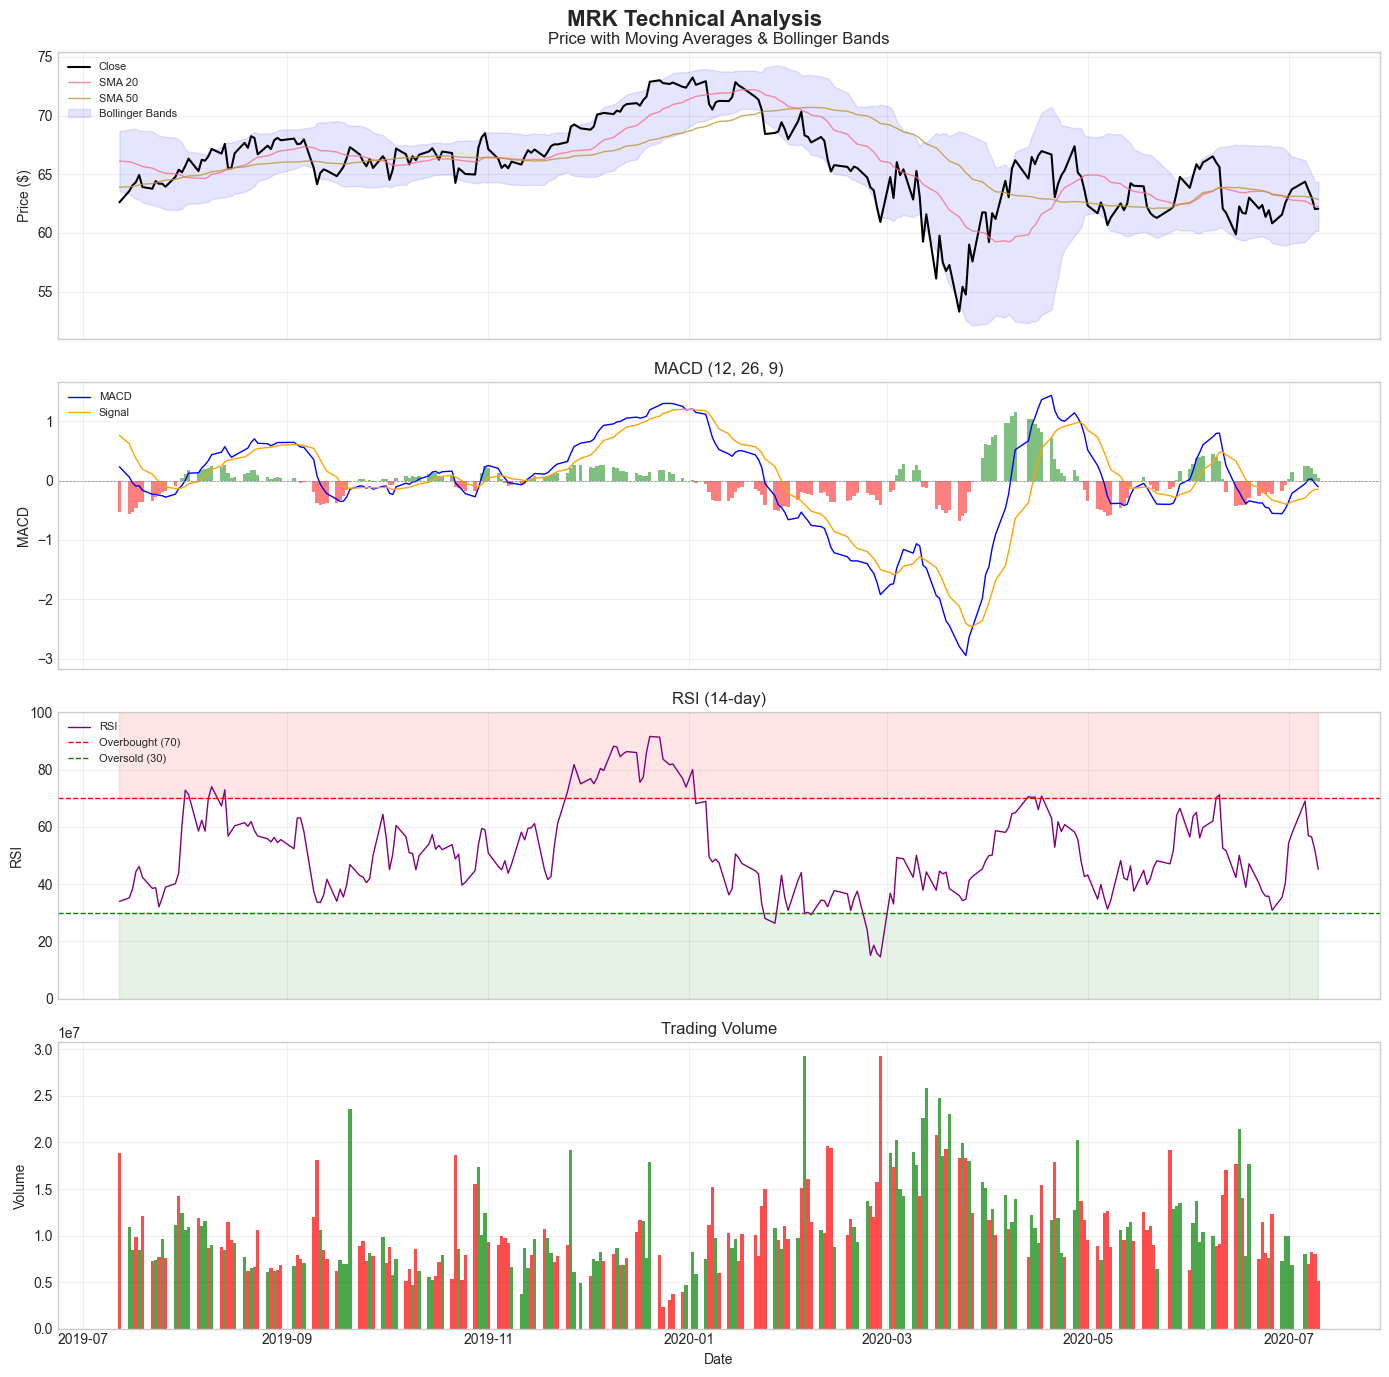

✓ Chart saved: MRK_technical_analysis.png


In [41]:
def plot_technical_analysis(symbol, data, days=252):
    """Create comprehensive technical analysis chart"""
    
    df = data.tail(days)  # Last N days
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
    fig.suptitle(f'{symbol} Technical Analysis', fontsize=16, fontweight='bold')
    
    # --- Plot 1: Price with Moving Averages & Bollinger Bands ---
    ax1 = axes[0]
    ax1.plot(df.index, df['Close'], label='Close', linewidth=1.5, color='black')
    ax1.plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1, alpha=0.8)
    ax1.plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1, alpha=0.8)
    ax1.fill_between(df.index, df['BB_Upper'], df['BB_Lower'], alpha=0.1, color='blue', label='Bollinger Bands')
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Price with Moving Averages & Bollinger Bands')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # --- Plot 2: MACD ---
    ax2 = axes[1]
    ax2.plot(df.index, df['MACD'], label='MACD', linewidth=1, color='blue')
    ax2.plot(df.index, df['MACD_Signal'], label='Signal', linewidth=1, color='orange')
    colors = ['green' if v >= 0 else 'red' for v in df['MACD_Hist']]
    ax2.bar(df.index, df['MACD_Hist'], color=colors, alpha=0.5, width=1)
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_ylabel('MACD')
    ax2.set_title('MACD (12, 26, 9)')
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # --- Plot 3: RSI ---
    ax3 = axes[2]
    ax3.plot(df.index, df['RSI'], label='RSI', color='purple', linewidth=1)
    ax3.axhline(y=70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
    ax3.axhline(y=30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
    ax3.fill_between(df.index, 70, 100, alpha=0.1, color='red')
    ax3.fill_between(df.index, 0, 30, alpha=0.1, color='green')
    ax3.set_ylabel('RSI')
    ax3.set_title('RSI (14-day)')
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # --- Plot 4: Volume ---
    ax4 = axes[3]
    colors = ['green' if df['Close'].iloc[i] >= df['Open'].iloc[i] else 'red' 
              for i in range(len(df))]
    ax4.bar(df.index, df['Volume'], color=colors, alpha=0.7, width=1)
    ax4.set_ylabel('Volume')
    ax4.set_title('Trading Volume')
    ax4.set_xlabel('Date')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/{symbol}_technical_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Plot for first stock
first_symbol = list(stock_data.keys())[0]
plot_technical_analysis(first_symbol, stock_data[first_symbol])
print(f"✓ Chart saved: {first_symbol}_technical_analysis.png")

#### Financial Metrics Summary Table

In [7]:
# Calculate summary metrics for all stocks
def calculate_metrics(symbol, df):
    """Calculate key financial metrics"""
    returns = df['Daily_Return'].dropna()
    
    # Annualized metrics (252 trading days)
    ann_return = returns.mean() * 252
    ann_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = ann_return / ann_volatility if ann_volatility != 0 else 0
    
    return {
        'Symbol': symbol,
        'Current Price': df['Close'].iloc[-1],
        'Avg Daily Return (%)': returns.mean(),
        'Daily Volatility (%)': returns.std(),
        'Ann. Return (%)': ann_return,
        'Ann. Volatility (%)': ann_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': returns.min(),
        'Best Day (%)': returns.max(),
        'Current RSI': df['RSI'].iloc[-1],
        'Price vs SMA20 (%)': ((df['Close'].iloc[-1] / df['SMA_20'].iloc[-1]) - 1) * 100
    }

# Generate metrics for all stocks
metrics_list = [calculate_metrics(sym, data) for sym, data in stock_data.items()]
metrics_df = pd.DataFrame(metrics_list)

print("=" * 70)
print("FINANCIAL METRICS SUMMARY")
print("=" * 70)
print(metrics_df.round(2).to_string(index=False))

# Save to CSV
metrics_df.to_csv('../notebooks/stock_metrics_summary.csv', index=False)
print("\n✓ Metrics saved to stock_metrics_summary.csv")

FINANCIAL METRICS SUMMARY
Symbol  Current Price  Avg Daily Return (%)  Daily Volatility (%)  Ann. Return (%)  Ann. Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Best Day (%)  Current RSI  Price vs SMA20 (%)
   MRK          62.06                  0.06                  1.31            14.77                20.80          0.71             -8.90         10.41        45.19               -0.30
    MS          41.85                  0.06                  2.30            13.92                36.50          0.38            -15.60         19.77        59.52                4.18
  NVDA          10.44                  0.16                  2.61            40.61                41.42          0.98            -18.76         29.81        74.07               10.02
    MU          49.49                  0.11                  3.07            28.05                48.66          0.58            -19.82         23.44        49.55                1.52
   QQQ         256.03                  0.08                

#### Compare all stocks

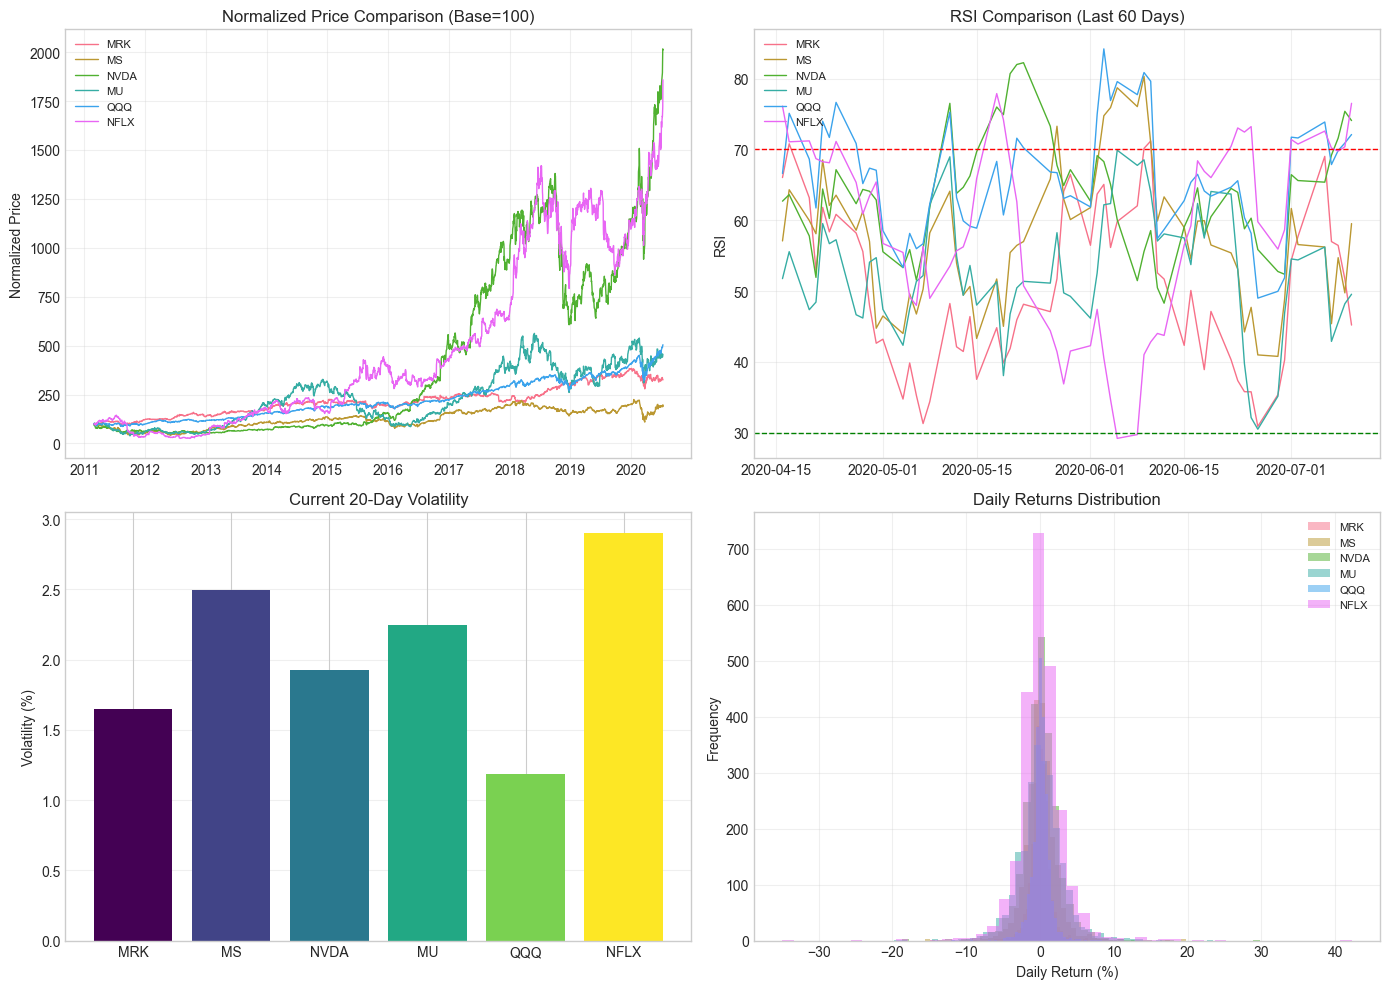

✓ Comparison chart saved


In [ ]:
# Visual comparison of all stocks
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Normalized Price Comparison
ax1 = axes[0, 0]
for symbol, df in stock_data.items():
    normalized = df['Close'] / df['Close'].iloc[0] * 100
    ax1.plot(df.index, normalized, label=symbol, linewidth=1)
ax1.set_title('Normalized Price Comparison (Base=100)')
ax1.set_ylabel('Normalized Price')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: RSI Comparison
ax2 = axes[0, 1]
for symbol, df in stock_data.items():
    ax2.plot(df.index[-60:], df['RSI'].iloc[-60:], label=symbol, linewidth=1)
ax2.axhline(y=70, color='red', linestyle='--', linewidth=1)
ax2.axhline(y=30, color='green', linestyle='--', linewidth=1)
ax2.set_title('RSI Comparison (Last 60 Days)')
ax2.set_ylabel('RSI')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Volatility Comparison
ax3 = axes[1, 0]
volatilities = [stock_data[s]['Volatility'].iloc[-1] for s in stock_data]
colors = plt.cm.viridis(np.linspace(0, 1, len(stock_data)))
bars = ax3.bar(stock_data.keys(), volatilities, color=colors)
ax3.set_title('Current 20-Day Volatility')
ax3.set_ylabel('Volatility (%)')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Returns Distribution
ax4 = axes[1, 1]
for symbol, df in stock_data.items():
    ax4.hist(df['Daily_Return'].dropna(), bins=50, alpha=0.5, label=symbol)
ax4.set_title('Daily Returns Distribution')
ax4.set_xlabel('Daily Return (%)')
ax4.set_ylabel('Frequency')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/stock_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Comparison chart saved to reports/figures/stock_comparison.png")

#### Task 2 Summary 

#### Financial Risk Metrics


In [38]:
# Import financial metrics module
sys.path.insert(0, '../src')
from metrics import FinancialMetrics, calculate_metrics

# Calculate comprehensive financial metrics for all stocks
print("=" * 80)
print("FINANCIAL RISK METRICS - SHARPE RATIO, SORTINO RATIO, VOLATILITY, MAX DRAWDOWN")
print("=" * 80)

financial_metrics_results = {}

for symbol, df_stock in stock_data.items():
    try:
        # Initialize metrics calculator
        fm = FinancialMetrics(df_stock, risk_free_rate=0.02)
        
        # Get comprehensive summary
        metrics_summary = fm.get_summary()
        financial_metrics_results[symbol] = metrics_summary
        
        print(f"\n{symbol} - Metrics Summary:")
        print(f"  Cumulative Return:      {metrics_summary['Cumulative Return (%)']:>10.2f}%")
        print(f"  Annual Return:          {metrics_summary['Annual Return (%)']:>10.2f}%")
        print(f"  Annual Volatility:      {metrics_summary['Annual Volatility (%)']:>10.2f}%")
        print(f"  Sharpe Ratio:           {metrics_summary['Sharpe Ratio']:>10.3f}  (excess return/risk)")
        print(f"  Sortino Ratio:          {metrics_summary['Sortino Ratio']:>10.3f}  (downside risk-adjusted)")
        print(f"  Calmar Ratio:           {metrics_summary['Calmar Ratio']:>10.3f}  (return/max drawdown)")
        print(f"  Max Drawdown:           {metrics_summary['Max Drawdown (%)']:>10.2f}%")
        print(f"  Win Rate:               {metrics_summary['Win Rate (%)']:>10.2f}%")
        print(f"  Best Day:               {metrics_summary['Best Day (%)']:>10.2f}%")
        print(f"  Worst Day:              {metrics_summary['Worst Day (%)']:>10.2f}%")
        print(f"  VaR 95%:                {metrics_summary['VaR 95% (%)']:>10.2f}%")
        
    except Exception as e:
        print(f"  Error calculating metrics for {symbol}: {e}")

# Create summary DataFrame for comparison
print("\n" + "=" * 80)
print("METRICS COMPARISON TABLE")
print("=" * 80)

if not financial_metrics_results:
    print("No financial metrics computed. Ensure stock_data contains 'Close' and is non-empty.")
else:
    metrics_comparison = pd.DataFrame(financial_metrics_results).T
    columns = [
        'Cumulative Return (%)',
        'Annual Return (%)',
        'Annual Volatility (%)',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Max Drawdown (%)'
    ]
    metrics_display = metrics_comparison[columns].round(3)

    print("\n" + metrics_display.to_string())

    # Identify key patterns
    print("\n" + "=" * 80)
    print("KEY INSIGHTS FROM RISK METRICS")
    print("=" * 80)

    sharpe_ratios = metrics_comparison['Sharpe Ratio'].sort_values(ascending=False)
    print(f"\nHighest Sharpe Ratio (Best Risk-Adjusted Return):")
    for symbol, ratio in sharpe_ratios.head(3).items():
        print(f"  {symbol}: {ratio:.3f}")

    sortino_ratios = metrics_comparison['Sortino Ratio'].sort_values(ascending=False)
    print(f"\nHighest Sortino Ratio (Best Downside Risk Management):")
    for symbol, ratio in sortino_ratios.head(3).items():
        print(f"  {symbol}: {ratio:.3f}")

    max_drawdowns = metrics_comparison['Max Drawdown (%)'].sort_values()
    print(f"\nLowest Max Drawdown (Least Severe Peak-to-Trough Decline):")
    for symbol, dd in max_drawdowns.head(3).items():
        print(f"  {symbol}: {dd:.2f}%")

    volatilities = metrics_comparison['Annual Volatility (%)'].sort_values()
    print(f"\nLowest Volatility (Most Stable):")
    for symbol, vol in volatilities.head(3).items():
        print(f"  {symbol}: {vol:.2f}%")

print("\n✓ Financial metrics calculated successfully")


FINANCIAL RISK METRICS - SHARPE RATIO, SORTINO RATIO, VOLATILITY, MAX DRAWDOWN

MRK - Metrics Summary:
  Cumulative Return:          225.11%
  Annual Return:               14.77%
  Annual Volatility:           20.80%
  Sharpe Ratio:                0.709  (excess return/risk)
  Sortino Ratio:               1.011  (downside risk-adjusted)
  Calmar Ratio:                0.542  (return/max drawdown)
  Max Drawdown:               -27.26%
  Win Rate:                    51.42%
  Best Day:                    10.41%
  Worst Day:                   -8.90%
  VaR 95%:                     -1.97%

MS - Metrics Summary:
  Cumulative Return:           97.54%
  Annual Return:               13.92%
  Annual Volatility:           36.50%
  Sharpe Ratio:                0.381  (excess return/risk)
  Sortino Ratio:               0.521  (downside risk-adjusted)
  Calmar Ratio:                0.243  (return/max drawdown)
  Max Drawdown:               -57.29%
  Win Rate:                    50.87%
  Best Day:     

In [40]:
print("=" * 80)
print("TASK 2 SUMMARY: QUANTITATIVE ANALYSIS WITH TECHNICAL INDICATORS & RISK METRICS")
print("=" * 80)

print(f"""
Stocks Analyzed: {list(stock_data.keys())}
Date Range: {start_date} to {end_date}

═══════════════════════════════════════════════════════════════════════════════
TECHNICAL INDICATORS IMPLEMENTED (TA-Lib & Custom)
═══════════════════════════════════════════════════════════════════════════════
  ✓ Simple Moving Averages (SMA 20, 50)      - Trend identification
  ✓ Exponential Moving Averages (EMA 12, 26) - Faster trend response
  ✓ MACD (12, 26, 9)                         - Momentum & trend changes
  ✓ RSI (14-day)                             - Overbought/oversold conditions
  ✓ Bollinger Bands (20-day, 2σ)             - Volatility & support/resistance
  ✓ Stochastic Oscillator (%K, %D)           - Momentum reversal signals
  ✓ Average True Range (ATR)                 - Volatility measurement
  ✓ On-Balance Volume (OBV)                  - Volume trend confirmation

═══════════════════════════════════════════════════════════════════════════════
QUANTITATIVE ANALYSIS FINDINGS - KEY BULLET POINTS
═══════════════════════════════════════════════════════════════════════════════
""")

# Generate dynamic bullet points from stock_data and computed metrics
print("1. RSI SIGNAL ANALYSIS:")
for symbol in stock_data:
    try:
        current_rsi = stock_data[symbol]['RSI'].iloc[-1]
        rsi_status = "OVERBOUGHT" if current_rsi > 70 else "OVERSOLD" if current_rsi < 30 else "NEUTRAL"
        print(f"   • {symbol}: RSI = {current_rsi:.1f} ({rsi_status})")
    except Exception:
        print(f"   • {symbol}: RSI not available")

print("\n2. MOVING AVERAGE CROSSOVER SIGNALS (Price vs SMA20):")
for symbol in stock_data:
    try:
        price = stock_data[symbol]['Close'].iloc[-1]
        sma20 = stock_data[symbol]['SMA_20'].iloc[-1]
        trend = "ABOVE" if price > sma20 else "BELOW"
        pct = (price / sma20 - 1) * 100
        print(f"   • {symbol}: Price {trend} SMA20 by {abs(pct):.1f}%")
    except Exception:
        print(f"   • {symbol}: SMA20 data not available")

print("\n3. VOLATILITY & BOLLINGER BAND SQUEEZES:")
for symbol in stock_data:
    try:
        bb_width = stock_data[symbol]['BB_Upper'].iloc[-1] - stock_data[symbol]['BB_Lower'].iloc[-1]
        bb_mean = (stock_data[symbol]['BB_Upper'] - stock_data[symbol]['BB_Lower']).mean()
        bb_ratio = (bb_width / bb_mean) * 100 if bb_mean != 0 else 100
        condition = "SQUEEZE" if bb_ratio < 70 else "EXPANSION" if bb_ratio > 130 else "NORMAL"
        print(f"   • {symbol}: Bollinger Band Width = {bb_width:.2f} ({condition})")
    except Exception:
        print(f"   • {symbol}: Bollinger Bands not available")

print("\n4. MOMENTUM SIGNALS FROM MACD CROSSOVERS:")
for symbol in stock_data:
    try:
        macd = stock_data[symbol]['MACD'].iloc[-1]
        macd_sig = stock_data[symbol]['MACD_Signal'].iloc[-1]
        hist = stock_data[symbol]['MACD_Hist'].iloc[-1]
        macd_signal = "BULLISH" if macd > macd_sig else "BEARISH"
        print(f"   • {symbol}: MACD = {macd:.4f}, Signal = {macd_sig:.4f}, Histogram = {hist:.4f} ({macd_signal})")
    except Exception:
        print(f"   • {symbol}: MACD not available")

print("\n5. RISK-ADJUSTED RETURN METRICS (Sharpe & Sortino Ratios):")
try:
    if financial_metrics_results:
        sorted_sharpe = sorted(financial_metrics_results.items(), key=lambda x: x[1].get('Sharpe Ratio', 0), reverse=True)
        for symbol, metrics in sorted_sharpe[:3]:
            print(f"   • {symbol}: Sharpe = {metrics.get('Sharpe Ratio', float('nan')):.3f}, Sortino = {metrics.get('Sortino Ratio', float('nan')):.3f}")
    else:
        print("   • Financial metrics not available")
except Exception:
    print("   • Error retrieving risk metrics")

print("\n6. MAXIMUM DRAWDOWN & VOLATILITY ANALYSIS:")
try:
    if financial_metrics_results:
        sorted_dd = sorted(financial_metrics_results.items(), key=lambda x: x[1].get('Max Drawdown (%)', 0))
        for symbol, metrics in sorted_dd[:3]:
            print(f"   • {symbol}: Max Drawdown = {metrics.get('Max Drawdown (%)', float('nan')):.2f}%, Volatility = {metrics.get('Annual Volatility (%)', float('nan')):.2f}%")
    else:
        print("   • Financial drawdown metrics not available")
except Exception:
    print("   • Error retrieving drawdown metrics")

print("\n7. WIN RATE & DAILY RETURN STATISTICS:")
try:
    if financial_metrics_results:
        sorted_win = sorted(financial_metrics_results.items(), key=lambda x: x[1].get('Win Rate (%)', 0), reverse=True)
        for symbol, metrics in sorted_win[:3]:
            cum_return = metrics.get('Cumulative Return (%)', float('nan'))
            win_rate = metrics.get('Win Rate (%)', float('nan'))
            print(f"   • {symbol}: Cumulative Return = {cum_return:.2f}%, Win Rate = {win_rate:.1f}%")
    else:
        print("   • Win rate metrics not available")
except Exception:
    print("   • Error retrieving win rate metrics")

print("\n" + "=" * 80)
print("✓ Task 2 analysis complete: Technical indicators + Risk metrics integrated")
print("=" * 80)


TASK 2 SUMMARY: QUANTITATIVE ANALYSIS WITH TECHNICAL INDICATORS & RISK METRICS

Stocks Analyzed: ['MRK', 'MS', 'NVDA', 'MU', 'QQQ', 'NFLX']
Date Range: 2011-02-26 to 2020-07-11

═══════════════════════════════════════════════════════════════════════════════
TECHNICAL INDICATORS IMPLEMENTED (TA-Lib & Custom)
═══════════════════════════════════════════════════════════════════════════════
  ✓ Simple Moving Averages (SMA 20, 50)      - Trend identification
  ✓ Exponential Moving Averages (EMA 12, 26) - Faster trend response
  ✓ MACD (12, 26, 9)                         - Momentum & trend changes
  ✓ RSI (14-day)                             - Overbought/oversold conditions
  ✓ Bollinger Bands (20-day, 2σ)             - Volatility & support/resistance
  ✓ Stochastic Oscillator (%K, %D)           - Momentum reversal signals
  ✓ Average True Range (ATR)                 - Volatility measurement
  ✓ On-Balance Volume (OBV)                  - Volume trend confirmation

════════════════════════════

#### TA-Lib Validation (Automated)

This section runs a validation that compares the pandas-based indicator calculations with TA-Lib's implementations. It prints the comparison summary and writes a JSON file to `reports/figures/validation_<SYMBOL>.json`. If TA-Lib is not installed the output will indicate so and the pipeline will continue using the pandas fallbacks.

In [ ]:
import json
import importlib.util
from pathlib import Path
# Load technical_indicators.py directly to avoid importing package-level deps
repo_root = Path('..')
ti_path = repo_root / 'src' / 'technical_indicators.py'
spec = importlib.util.spec_from_file_location('ti_local', str(ti_path))
ti_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ti_mod)
TechnicalIndicators = ti_mod.TechnicalIndicators
# Choose a representative symbol (AAPL if present, else first available)
symbol = 'AAPL' if 'AAPL' in stock_data else list(stock_data.keys())[0]
df = stock_data[symbol]
ti = TechnicalIndicators()
validation = ti.validate_against_talib(df)
out_dir = Path('../reports/figures')
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / f'validation_{symbol}.json'
with out_file.open('w') as f:
    json.dump(validation, f, indent=2)
print('Validation result for', symbol)
print(json.dumps(validation, indent=2))
print('Saved to', out_file)
